---
title: "[Retrieval Performance Evaluation](https://www.kaggle.com/code/fanlcs/retrieval-performance-evaluation)"
---

This notebook focuses on the systematic evaluation of retrieval performance. It proceeds in three stages:

1. A synthetic legal question dataset is constructed by transforming a legal corpus into diverse natural-language queries, each paired with its reference law article(s).

2. The retrieval process is illustrated using a sampled query, demonstrating how candidate evidence is retrieved, expanded, and ranked in a step-by-step manner. This example provides intuition for the quantitative evaluations that follow.

3. Using the synthetic dataset, retrieval performance is evaluated comprehensively and quantitatively using retrieval metrics, including Recall@K, Hit@K, NDCG, and MRR.

In [ ]:
#| include: false

!git clone https://github.com/Fan-Luo/Legal-RAG.git
%cd Legal-RAG
!python -m scripts.setup

Cloning into 'Legal-RAG'...
remote: Enumerating objects: 751, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 751 (delta 186), reused 234 (delta 168), pack-reused 454 (from 1)
Receiving objects: 100% (751/751), 963.31 KiB | 8.68 MiB/s, done.
Resolving deltas: 100% (378/378), done.
/kaggle/working/Legal-RAG


In [ ]:
#| include: false

import os, re, json, random
import pandas as pd
from typing import Dict, List, Tuple, Optional, Any, Set
from pathlib import Path
import logging
from IPython.display import display
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

## Generate Synthetic Evaluation Dataset

Evaluating legal retrievers requires ground truth dataset with question–reference article pairs.

Generates synthetic legal questions by transforming legal corpus into natural-language queries makes it possible to evaluate retrieval behavior at scale.

In [ ]:
#| include: false

from legalrag.config import AppConfig
from legalrag.schemas import LawChunk, RetrievalHit
from legalrag.utils.logger import get_logger
from legalrag.llm.client import LLMClient
from sentence_transformers import SentenceTransformer

logger = get_logger(__name__)
cfg = AppConfig.load(None)
cfg.llm.provider = "qwen-local"
cfg.llm.model = "Qwen/Qwen2.5-3B-Instruct"

llm = LLMClient.from_config(cfg)
embedding_model = SentenceTransformer(cfg.retrieval.embedding_model)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2026-01-30 09:55:01.192365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769766901.412015      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769766901.480465      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769766902.022570      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769766902.022604      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769766902.022607      55 computation_placer.cc:177] computation placer alr

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
#| code-summary: "Load the law corpus and sample an example"

corpus = Path(cfg.paths.law_jsonl)
chunks = [json.loads(l) for l in corpus.open("r", encoding="utf-8") if l.strip()]
df_chunks = pd.DataFrame(chunks)

print("Example law chunk:", )
display(df_chunks.drop(columns=["subpart", "section", "article_key", "source"]).sample(1, random_state=1))
print("Number of law chunks:", len(df_chunks))

Example law chunk:


,id,law_name,part,chapter,article_no,article_id,text
1179,minfadian.txt::一千一百八十,中华人民共和国民法典,七编 侵权责任,二章 损害赔偿,第一千一百八十条,1180,第一千一百八十条 因同一侵权行为造成多人死亡的，可以以相同数额确定死亡赔偿金。


Number of law chunks: 1260


In [ ]:
#| code-summary: "Generate synthetic ground-truth legal query–evidence evaluation dataset"

from scripts.generate_synthetic_data import build_ground_truth_queries

df_queries = build_ground_truth_queries(
    df_chunks,
    per_article=2,
    max_articles=200,
    total_queries=150,
    logger=logger,
    zh_ratio=0.9,
    generator_llm=llm,
    judge_llm=llm,
    embedding_model=embedding_model
)

df_sample = df_queries.sample(5, random_state=1)
display(df_sample.drop(columns=["lang", "round", "rewritten", "score"]))
print("Generated queries count:", len(df_queries))

Generating queries:  24%|██▍       | 49/200 [22:26<1:09:09, 27.48s/it]


Generated queries count: 150


,query,role,law_name,article_no,article_id
14,听起来挺复杂的，那如果我在签署合同时已经意识到这些风险了，是否还能要求赔偿损失？,user,中华人民共和国民法典,第七百三十八条,738
98,最后一个问题了，这个规定适用于所有的技术咨询服务合同吗？,user,中华人民共和国民法典,第八百八十条,880
75,认购书或者订购书等是否属于预约合同？,user,中华人民共和国民法典,第四百九十五条,495
16,"When all parties sign, seal, or affix their fi...",inhouse,中华人民共和国民法典,第四百九十三条,493
131,当合同无效是由于承租人的不当行为引起时，租赁物的所有权归谁，承租人需不需要向出租人进行经济补偿？,lawyer,中华人民共和国民法典,第七百六十条,760


In [ ]:
#| include: false

from scripts.quiet import install_quiet
install_quiet()

## Illustrate Multi-channel Multi-stage Retrieval  

The retrieval pipeline in Legal-RAG is designed as a multi-stage, hybrid, and graph-aware process, balancing recall, precision, and interpretability. Rather than relying on a single retrieval signal, the retriever progressively refines candidates through multi-channel coarse retrieval, score fusion, graph expansion, and reranking.

In [ ]:
#| code-summary: "Sample a synthetic query to illustrate the retrieval pipeline"

sample = df_sample[["query", "article_id"]].sample(1)
display(sample)
question = sample["query"].values[0]

,query,article_id
75,认购书或者订购书等是否属于预约合同？,495


In [ ]:
#| include: false

from legalrag.retrieval.hybrid_retriever import HybridRetriever

retriever = HybridRetriever(cfg)
rcfg = retriever.cfg.retrieval

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")


artifact.metadata: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_xlm_roberta.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_xlm_roberta.py: 0.00B [00:00, ?B/s]

rotary.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


embedding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mlp.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py: 0.00B [00:00, ?B/s]

stochastic_depth.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- rotary.py
- embedding.py
- mha.py
- mlp.py
- xlm_padding.py
- block.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

[Jan 30, 09:56:06] #> Loading codec...
[Jan 30, 09:56:06] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
W0130 09:56:06.678000 55 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0130 09:56:06.678000 55 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[Jan 30, 09:57:11] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W0130 09:57:11.314000 55 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0130 09:57:11.314000 55 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[Jan 30, 09:58:13] #> Loading IVF...
[Jan 30, 09:58:13] #> Loading doclens...


100%|██████████| 1/1 [00:00<00:00, 2190.24it/s]

[Jan 30, 09:58:13] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 254.26it/s]


### Sparse lexical retrieval

Sparse lexical retrieval (BM25) preserves keyword and statutory phrase matching, performing pure text-based retrieval.


In [ ]:
#| include: false

from legalrag.schemas import RetrievalHit
from typing import Any, Optional, List
import pandas as pd

def hits_to_dataframe(
    hits: List[RetrievalHit],
    show_channel: bool = False,
) -> pd.DataFrame:
    rows = []
    for h in hits:
        c = h.chunk
        sb = getattr(h, "score_breakdown", None) or {}

        row = {
            "score": f"{float(getattr(h, 'score', 0.0) or 0.0):.2f}",
            "article_id": getattr(c, "article_id", ""),
            "chapter": getattr(c, "chapter", ""),
            "preview": (getattr(c, "text", "") or "").replace("\n", " ")[:80] + "...",
        }

        if show_channel:
            row["channel"] = sb.get("channel", "")

        rows.append(row)

    return pd.DataFrame(rows)

In [ ]:
#| echo: false
#| code-fold: false

top_k = 10
bm25_hits = retriever.search_bm25(question, top_k)
df_bm25 = hits_to_dataframe(bm25_hits)
display(df_bm25.head(5))

,score,article_id,chapter,preview
0,37.36,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...
1,8.09,1134,三章 遗嘱继承和遗赠,第一千一百三十四条 自书遗嘱由遗嘱人亲笔书写，签名，注明年、月、日。...
2,7.53,501,三章 合同的效力,第五百零一条 当事人在订立合同过程中知悉的商业秘密或者其他应当保密的信息，无论合同是否成立，...
3,7.47,250,五章 国家所有权和集体所有权、私人所有权,第二百五十条 森林、山岭、草原、荒地、滩涂等自然资源，属于国家所有，但是法律规定属于集体所有...
4,7.03,254,五章 国家所有权和集体所有权、私人所有权,第二百五十四条 国防资产属于国家所有。 铁路、公路、电力设施、电信设施和油气管道等基础设施，...


### Dense semantic retrieval

Dense retrieval (BGE embedding-based FAISS search) captures semantic similarity and paraphrased intent.

In [ ]:
#| echo: false
#| code-fold: false

dense_hits = retriever.search_dense(question, top_k)
df_dense = hits_to_dataframe(dense_hits)
display(df_dense.head(5))

initial target device:   0%|          | 0/2 [00:00<?, ?it/s]2026-01-30 09:58:56.754186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769767136.778012     349 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769767136.785092     349 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769767136.803314     349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769767136.803348     349 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769767136.8033

,score,article_id,chapter,preview
0,0.65,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...
1,0.53,491,二章 合同的订立,第四百九十一条 当事人采用信件、数据电文等形式订立合同要求签订确认书的，签订确认书时合同成立...
2,0.53,471,二章 合同的订立,第四百七十一条 当事人订立合同，可以采取要约、承诺方式或者其他方式。...
3,0.51,493,二章 合同的订立,第四百九十三条 当事人采用合同书形式订立合同的，最后签名、盖章或者按指印的地点为合同成立的地...
4,0.51,483,二章 合同的订立,第四百八十三条 承诺生效时合同成立，但是法律另有规定或者当事人另有约定的除外。...


### Late-interaction retrieval

Late-interaction retrieval (ColBERT) encodes each token into a contextualized embedding and computes relevance through fine-grained token–token interactions at query time. This design preserves detailed lexical signals while retaining strong semantic generalization.

In [ ]:
#| echo: false
#| code-fold: false

colbert_hits = retriever.search_colbert(question, top_k)
df_colbert = hits_to_dataframe(colbert_hits)
display(df_colbert.head(5))

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


,score,article_id,chapter,preview
0,22.08,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...
1,19.97,502,三章 合同的效力,第五百零二条 依法成立的合同，自成立时生效，但是法律另有规定或者当事人另有约定的除外。 依照...
2,19.92,493,二章 合同的订立,第四百九十三条 当事人采用合同书形式订立合同的，最后签名、盖章或者按指印的地点为合同成立的地...
3,19.88,888,二十一章 保管合同,第八百八十八条 保管合同是保管人保管寄存人交付的保管物，并返还该物的合同。 寄存人到保管人处...
4,19.84,984,二十九章 不当得利,第九百八十四条 管理人管理事务经受益人事后追认的，从管理事务开始时起，适用委托合同的有关规定...


### Multi-channel Retrieval Fusion

To integrate heterogeneous retrieval signals, Legal-RAG applies a fusion step over the multi-channel results. Two fusion strategies are supported:

- Reciprocal Rank Fusion (RRF)
Candidates are ranked based on the inverse of their rank positions across channels, emphasizing consensus among retrievers.

- Normalized score blending (norm_blend)
Raw scores from different retrievers are normalized into a comparable range and linearly combined.

This fusion step yields a unified ranked list of top candidates, mitigating the weaknesses of any single retrieval method.

In [ ]:
#| echo: false
#| code-fold: false

fusion_hits = retriever._fuse(
    dense_hits=dense_hits,
    bm25_hits=bm25_hits,
    colbert_hits=colbert_hits
)
min_final = float(getattr(rcfg, "min_final_score", 0.0))
fusion_hits = [h for h in fusion_hits if float(h.score) >= min_final]
df_fusion = hits_to_dataframe(fusion_hits, show_channel=True)
display(df_fusion.head(5))

,score,article_id,chapter,preview,channel
0,1.18,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...,"[dense, bm25, colbert]"
1,0.32,491,二章 合同的订立,第四百九十一条 当事人采用信件、数据电文等形式订立合同要求签订确认书的，签订确认书时合同成立...,"[dense, colbert]"
2,0.31,471,二章 合同的订立,第四百七十一条 当事人订立合同，可以采取要约、承诺方式或者其他方式。...,"[dense, colbert]"
3,0.30,493,二章 合同的订立,第四百九十三条 当事人采用合同书形式订立合同的，最后签名、盖章或者按指印的地点为合同成立的地...,"[dense, colbert]"
4,0.22,469,二章 合同的订立,第四百六十九条 当事人订立合同，可以采用书面形式、口头形式或者其他形式。 书面形式是合同书、...,"[colbert, dense]"


### Graph-Augmented Retrieval

To capture structural legal relationships, such as:

- General–specific rule hierarchies
- Cross-article references
- Implicit doctrinal dependencies
  
a graph-based enhancement stage is applied. Using the fusion top candidates as seeds, a graph walk augments the candidate set with structurally relevant but textually under-retrieved articles.

In [ ]:
#| include: false

seed_n = int(getattr(rcfg, "graph_seed_k", max(10, top_k * 3)))
seeds = fusion_hits[:seed_n]
df_seeds = hits_to_dataframe(seeds, show_channel=True)
display(df_seeds.head(5))

,score,article_id,chapter,preview,channel
0,1.18,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...,"[dense, bm25, colbert]"
1,0.32,491,二章 合同的订立,第四百九十一条 当事人采用信件、数据电文等形式订立合同要求签订确认书的，签订确认书时合同成立...,"[dense, colbert]"
2,0.31,471,二章 合同的订立,第四百七十一条 当事人订立合同，可以采取要约、承诺方式或者其他方式。...,"[dense, colbert]"
3,0.30,493,二章 合同的订立,第四百九十三条 当事人采用合同书形式订立合同的，最后签名、盖章或者按指印的地点为合同成立的地...,"[dense, colbert]"
4,0.22,469,二章 合同的订立,第四百六十九条 当事人订立合同，可以采用书面形式、口头形式或者其他形式。 书面形式是合同书、...,"[colbert, dense]"


In [ ]:
#| echo: false
#| code-fold: false

from legalrag.routing.router import QueryRouter

router = QueryRouter(llm_client=LLMClient.from_config(retriever.cfg), llm_based=retriever.cfg.routing.llm_based)
decision = router.route(question)

eff_top_k = int(getattr(rcfg, "top_k", top_k * 8) or (top_k * 8))
seeds = fusion_hits[:seed_n]
graph_hits = retriever.search_graph(question, eff_top_k, decision=decision, seeds=seeds)
df_graph = hits_to_dataframe(graph_hits)
display(df_graph.head(5))

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Chunks: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]


,score,article_id,chapter,preview
0,0.36,490,二章 合同的订立,第四百九十条 当事人采用合同书形式订立合同的，自当事人均签名、盖章或者按指印时合同成立。在签...
1,0.34,494,二章 合同的订立,第四百九十四条 国家根据抢险救灾、疫情防控或者其他需要下达国家订货任务、指令性任务的，有关民...
2,0.34,472,二章 合同的订立,第四百七十二条 要约是希望与他人订立合同的意思表示，该意思表示应当符合下列条件： （一）内容...
3,0.34,470,二章 合同的订立,第四百七十条 合同的内容由当事人约定，一般包括下列条款： （一）当事人的姓名或者名称和住所；...
4,0.33,492,二章 合同的订立,第四百九十二条 承诺生效的地点为合同成立的地点。 采用数据电文形式订立合同的，收件人的主营业...


### Reranking

A reranking stage using cross-encoder or LLM-based scoring refines ordering at the end.
Reranking prioritizes answer-critical provisions while demoting peripheral or weakly connected articles based on higher-resolution signals, such as:

- Query–article semantic alignment
- Coverage of legally salient terms

In [ ]:
#| echo: false
#| code-fold: false

hybrid_hits = retriever.search(question, llm,top_k=top_k, decision=decision)
df_hybrid = hits_to_dataframe(hybrid_hits, show_channel=True)
display(df_hybrid.head(10))

Chunks: 100%|██████████| 1/1 [00:00<00:00, 45.51it/s]
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

,score,article_id,chapter,preview,channel
0,1.11,495,二章 合同的订立,第四百九十五条 当事人约定在将来一定期限内订立合同的认购书、订购书、预订书等，构成预约合同。...,"[dense, bm25, colbert]"
1,0.21,491,二章 合同的订立,第四百九十一条 当事人采用信件、数据电文等形式订立合同要求签订确认书的，签订确认书时合同成立...,"[dense, colbert]"
2,0.20,471,二章 合同的订立,第四百七十一条 当事人订立合同，可以采取要约、承诺方式或者其他方式。...,"[dense, colbert]"
3,0.19,493,二章 合同的订立,第四百九十三条 当事人采用合同书形式订立合同的，最后签名、盖章或者按指印的地点为合同成立的地...,"[dense, colbert]"
4,0.15,469,二章 合同的订立,第四百六十九条 当事人订立合同，可以采用书面形式、口头形式或者其他形式。 书面形式是合同书、...,"[colbert, dense]"


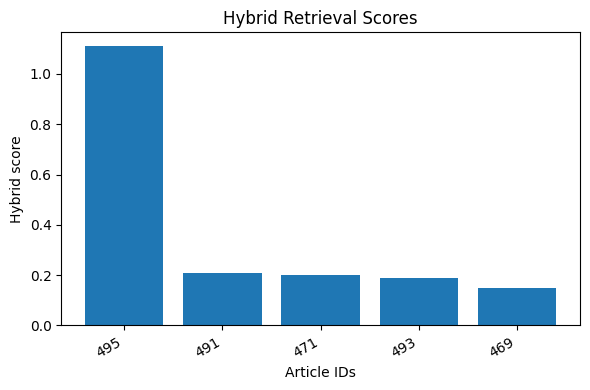

In [ ]:
#| echo: false
#| code-fold: false

import matplotlib.pyplot as plt
plt.close('all')

def plot_hybrid_scores(df_hybrid: pd.DataFrame, question: str):
    if df_hybrid.empty:
        print("No hybrid hits to plot.")
        return

    df = df_hybrid.sort_values("score", ascending=False).reset_index(drop=True)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    df = df.dropna(subset=["score"])
    scores = df["score"].values

    df["rank"] = range(1, len(df) + 1)

    ranks = df["rank"].values

    labels = df["article_id"].values

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.bar(ranks, scores)
    ax.set_xticks(ranks)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_xlabel("Article IDs")
    ax.set_ylabel("Hybrid score")
    ax.set_title(f"Hybrid Retrieval Scores")

    plt.tight_layout()
    plt.show()

plot_hybrid_scores(df_hybrid, question)

## Evaluating Retrieval Pipelines with Synthetic Questions


The generated synthetic dataset is used for systematic evaluation of retrieval performance in each stage:


- Multi-Channel Retrieval, combining dense semantic search, sparse lexical matching, and late-interaction models.  

- Graph-Augmented Retrieval, with legal graph expansion.

- Reranking, final ranking by applying a cross-encoder or LLM.


In [ ]:
#| code-summary: "Define Retrieval Evaluation Metrics"

from collections import defaultdict
from typing import Callable
import math


def _hit_ids(hits: List[RetrievalHit]) -> List[str]:
    # compare at article_id level for legal retrieval
    out = []
    for h in hits:
        aid = str(getattr(h.chunk, "article_id", "") or "")
        if aid:
            out.append(aid)
    return out

def hit_at_k(pred: List[str], gold: Set[str], k: int) -> float:
    top_hits = pred[:k]
    return int(any(h.strip() in gold for h in top_hits))

def recall_at_k(pred: List[str], gold: Set[str], k: int) -> float:
    if not gold:
        return 0.0
    return len(set(pred[:k]) & gold) / len(gold)

def mrr_at_k(pred: List[str], gold: Set[str], k: int) -> float:
    for i, x in enumerate(pred[:k], start=1):
        if x in gold:
            return 1.0 / i
    return 0.0

def ndcg_at_k(pred: List[str], gold: Set[str], k: int) -> float:
    # binary relevance
    def dcg(xs: List[str]) -> float:
        s = 0.0
        for i, x in enumerate(xs[:k], start=1):
            rel = 1.0 if x in gold else 0.0
            s += rel / math.log2(i + 1)
        return s
    ideal = dcg(list(gold))
    if ideal <= 1e-12:
        return 0.0
    return dcg(pred) / ideal


In [ ]:
#| echo: false
#| code-fold: false

def evaluate_one(query: str, positives: List[str], top_k: int = 20) -> Dict[str, Any]:
    gold = set(map(str, positives))

    rcfg = retriever.cfg.retrieval
    router = QueryRouter(llm_client=LLMClient.from_config(retriever.cfg), llm_based=retriever.cfg.routing.llm_based)
    decision = router.route(query)
    top_k = max(1, int(top_k))
    eff_top_k = int(getattr(rcfg, "top_k", top_k * 8) or (top_k * 8))
    if eff_top_k < top_k:
        eff_top_k = top_k

    dense_hits = retriever.search_dense(query, eff_top_k)
    bm25_hits = retriever.search_bm25(query, eff_top_k)
    colbert_hits =  retriever.search_colbert(query, eff_top_k)
    seed_n = int(getattr(rcfg, "graph_seed_k", max(10, top_k * 3)))

    # -----------------------
    # Fusion
    # -----------------------
    fusion_hits = retriever._fuse(
        dense_hits=dense_hits,
        bm25_hits=bm25_hits,
        colbert_hits=colbert_hits,
    )
    min_final = float(getattr(rcfg, "min_final_score", 0.0))
    fusion_hits = [h for h in fusion_hits if float(h.score) >= min_final]

    # -----------------------
    # Graph Augment
    # -----------------------
    seeds = fusion_hits[:seed_n]
    graph_hits = retriever.search_graph(query, eff_top_k, decision=decision, seeds=seeds)
    fusion_hits = seeds + graph_hits

    # -----------------------
    # HybridRetriever.search()
    # -----------------------
    hybrid_hits = retriever.search(query, llm, top_k, decision)

    hits = {
        "bm25": _hit_ids(bm25_hits),
        "dense": _hit_ids(dense_hits),
        "colbert": _hit_ids(colbert_hits),
        "fusion": _hit_ids(fusion_hits),
        "hybrid": _hit_ids(hybrid_hits),
    }

    metrics = {}
    for name, pred in hits.items():
        metrics[name] = {
            "R@5": recall_at_k(pred, gold, 5),
            "R@10": recall_at_k(pred, gold, 10),
            "MRR@10": mrr_at_k(pred, gold, 10),
            "nDCG@10": ndcg_at_k(pred, gold, 10),
            "hit@3": hit_at_k(pred, gold, 3),
            "hit@10": hit_at_k(pred, gold, 10),
        }

    return {"hits": hits, "metrics": metrics}

def flatten_metrics(res: List[Dict[str, Any]]) -> pd.DataFrame:
    rows = []
    for r in res:
        for sys, ms in r["metrics"].items():
            rows.append({
                "query": r["query"],
                "retriever": sys,
                **ms
            })
    return pd.DataFrame(rows)

In [ ]:
#| code-summary: "Evaluate on the Systematic Dataset"

subset = df_queries.sample(100, random_state=0).reset_index(drop=True)

results = []
for _, row in subset.iterrows():
    out = evaluate_one(row["query"], [row["article_id"]], top_k=10)
    results.append({
        "query": row["query"],
        "positives": row["article_id"],
        "hits":  out["hits"],
        "metrics": out["metrics"],
    })

In [ ]:
#| echo: false
#| code-fold: false

dfm = flatten_metrics(results)
summary = dfm.groupby("retriever")[["R@5","R@10","MRR@10","nDCG@10", "hit@3", "hit@10"]].mean().sort_values("R@10", ascending=False)
summary


,R@5,R@10,MRR@10,nDCG@10,hit@3,hit@10
fusion,0.82,0.85,0.650857,0.699083,0.70,0.85
hybrid,0.82,0.84,0.690524,0.727520,0.75,0.84
colbert,0.79,0.81,0.663024,0.699208,0.71,0.81
dense,0.66,0.75,0.528690,0.582100,0.60,0.75
bm25,0.52,0.57,0.443345,0.473788,0.49,0.57


In [ ]:
#| include: false

results[0]

{'query': "What specific remedies does the law allow when work delivered by the contractor doesn't meet quality standards?",
 'positives': '781',
 'hits': {'bm25': ['1126',
   '14',
   '77',
   '1120',
   '252',
   '789',
   '60',
   '109',
   '543',
   '1055'],
  'dense': ['781',
   '616',
   '615',
   '636',
   '775',
   '617',
   '776',
   '610',
   '635',
   '780'],
  'colbert': ['801',
   '781',
   '806',
   '800',
   '610',
   '617',
   '1252',
   '621',
   '907',
   '793'],
  'fused': ['781',
   '617',
   '610',
   '616',
   '615',
   '1126',
   '636',
   '801',
   '582',
   '510',
   '583',
   '511',
   '584',
   '618',
   '800',
   '635',
   '780',
   '611'],
  'hybrid': ['781', '617', '610', '801', '616', '615', '636', '1126']},
 'metrics': {'bm25': {'R@5': 0.0,
   'R@10': 0.0,
   'MRR@10': 0.0,
   'nDCG@10': 0.0,
   'hit@3': 0,
   'hit@10': 0},
  'dense': {'R@5': 1.0,
   'R@10': 1.0,
   'MRR@10': 1.0,
   'nDCG@10': 1.0,
   'hit@3': 1,
   'hit@10': 1},
  'colbert': {'R@5': 1.

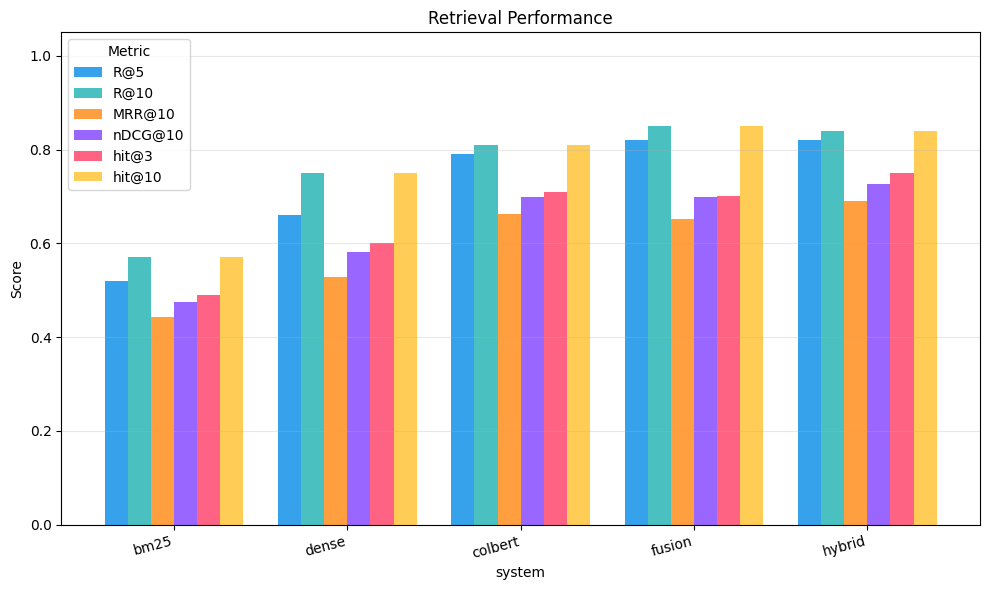

In [ ]:
#| echo: false
#| code-fold: false

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
order = ['bm25', 'dense', 'colbert', 'fusion', 'hybrid']

summary = summary.reindex(order)
summary.plot(kind='bar', figsize=(10,6), width=0.8,
             color = ['#36A2EB', # blue
                       '#4BC0C0', # teal
                       '#FF9F40', # orange
                       '#9966FF', # purple
                       '#FF6384', # pink
                       '#FFCD56' # yellow
                      ],
             title='Retrieval Performance')

plt.ylabel('Score')
plt.xlabel("Retriever")
plt.ylim(0, 1.05)
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

## Key observations

1. Neural retrieval consistently outperforms lexical BM25.
Both dense and ColBERT retrievers achieve substantial gains over BM25 across all metrics (e.g., R@10, MRR@10, nDCG@10), indicating that semantic matching is essential for legal queries with abstract or paraphrased formulations.

2. Late-interaction retrieval (ColBERT) further improves ranking quality.
Compared to standard dense retrieval, ColBERT yields higher nDCG@10 and hit@k scores, suggesting better fine-grained alignment between queries and statutory text.

3. Multi-retriever fusion provides robust and consistent improvements.
The fusion variant, which combines BM25, dense, and ColBERT retrieval results, achieves the strongest overall recall and ranking performance, benefiting from complementary retrieval signals.

4. Hybrid retrieval with augmentation and reranking achieves the best performance.
The hybrid retriever—built on top of fusion and further enhanced with optional graph-based augmentation and reranking—consistently attains the highest scores across nearly all metrics.
In particular, it shows clear gains over pure BM25 and pure dense retrieval, confirming the effectiveness of combining heterogeneous retrievers with structural and ranking enhancements.

Overall, the results demonstrate that progressively enriched retrieval pipelines—from lexical to semantic, from single retriever to fused and augmented retrievers—lead to systematic and measurable improvements in legal retrieval quality.